In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt

# insert the mymujoco path for TrainDQN.py file
sys.path.insert(0, "/home/luke/mymujoco/rl")

# create modelsaver instance
from ModelSaver import ModelSaver
saver = ModelSaver("test_data", root="/home/luke/gripper-ros/")

from grasp_test_data import GraspTestData
data_explorer = GraspTestData()

# enter folder and load test data
test_name = "pb4_EI1_S3"
saver.enter_folder(test_name)
try:
  testdata = saver.load(id=None, filenamestarts="test_data_edited", suffix_numbering=True)
  print(data_explorer.get_test_string(data=testdata, detailed=False))
except TypeError as e:
  print("Loading test data failed, check that the test has actually saved some data")
  print("Error was:", e)

Loading file /home/luke/gripper-ros/test_data/pb4_EI1_S3/test_data_edited_001.pbz2 with pickle ... finished
Test information

Test name: pb4_EI1_S3
Finger width: 0.028
Finger thickness: 0.0009
heuristic test: False
Bending gauge in use: True
Palm sensor in use: True
Wrist Z sensor in use: True
Loaded group name: 07-03-23
Loaded run name: luke-PC_13:37_A10
Loaded best SR: 0.837

Results information:

Sphere success rate: 0.8333
cylinder success rate: 0.8667
cuboid success rate: 0.8667
cube success rate: 0.8667

Total number of trials: 150
Total number of objects: 30
Overall success rate: 0.8600



In [4]:
# optionally also print trial information
print_trials = True
_ = data_explorer.get_test_results(data=testdata, print_trials=print_trials)

Object num = 2, num trials = 5, TH = 5 SH = 5
Object num = 1, num trials = 5, TH = 4 SH = 2
Object num = 3, num trials = 5, TH = 5 SH = 5
Object num = 4, num trials = 5, TH = 5 SH = 5
Object num = 5, num trials = 5, TH = 3 SH = 3
Object num = 7, num trials = 5, TH = 5 SH = 5
Object num = 9, num trials = 5, TH = 5 SH = 5
Object num = 10, num trials = 5, TH = 5 SH = 5
Object num = 11, num trials = 5, TH = 2 SH = 2
Object num = 12, num trials = 5, TH = 5 SH = 5
Object num = 13, num trials = 5, TH = 3 SH = 3
Object num = 14, num trials = 5, TH = 4 SH = 4
Object num = 16, num trials = 5, TH = 4 SH = 3
Object num = 17, num trials = 5, TH = 4 SH = 4
Object num = 18, num trials = 5, TH = 5 SH = 5
Object num = 19, num trials = 5, TH = 5 SH = 5
Object num = 20, num trials = 5, TH = 5 SH = 5
Object num = 21, num trials = 5, TH = 4 SH = 4
Object num = 23, num trials = 5, TH = 5 SH = 5
Object num = 24, num trials = 5, TH = 5 SH = 5
Object num = 25, num trials = 5, TH = 5 SH = 5
Object num = 26, num

In [21]:
# edit individual trials to fix errors
if False:
  
  for trial in testdata.trials:

    if trial.object_num in [6, 8, 15, 22]:
      if trial.trial_num < 6:
        trial.object_num += 100

  for trial in testdata.trials:
    if trial.object_num == 1: trial.object_num = 2

  for trial in testdata.trials:
    if trial.object_num == 0: trial.object_num = 1

  saver.save("test_data_edited", pyobj=testdata)

Saving file /home/luke/gripper-ros/test_data/pb4_EI1_S3/test_data_edited_001.pbz2 with pickle ... finished


Loading file /home/luke/gripper-ros/test_data/pb4_EI1_S3/trial_image_batch_135.pbz2 with pickle ... finished
There are 101 images


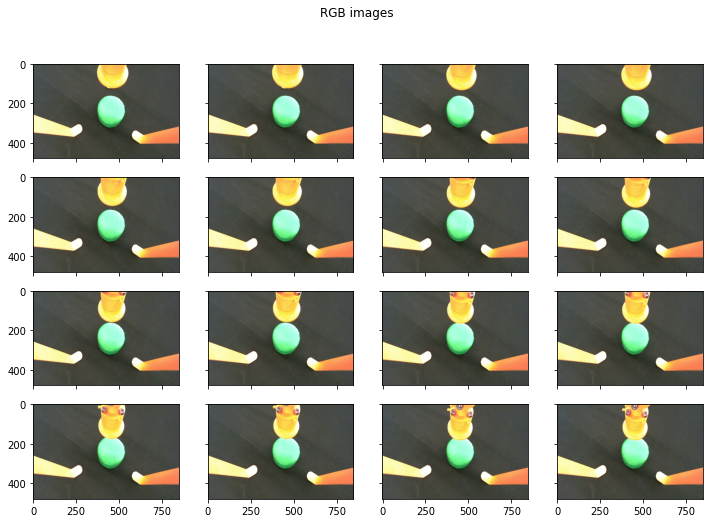

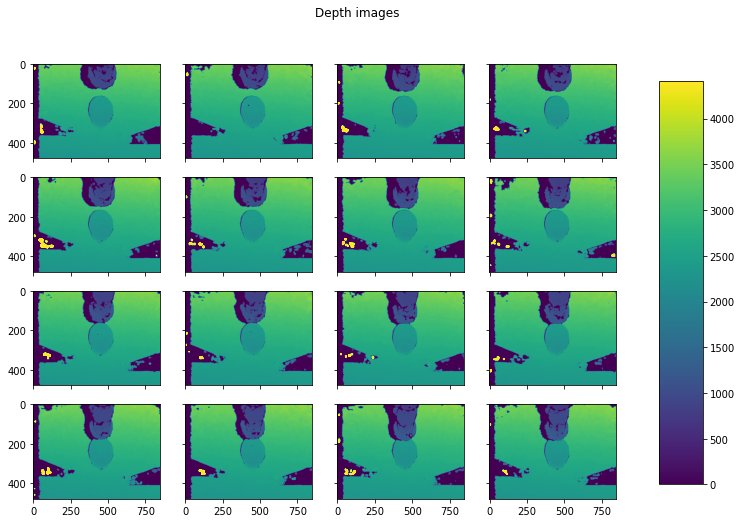

In [10]:
# prepare to load image data
new_test = True
if new_test:
  test_name = "pb4_EI1_S3"
  saver.enter_folder(test_name)

# extract the image data
imagedata = saver.load(id=None, filenamestarts="trial_image_batch")
image_list = imagedata.trials[0].images
print("There are", len(image_list), "images")

# how many images would we like to plot
rows = 4
cols = 4

num_images = rows * cols
if num_images > len(image_list): num_images = len(image_list)

fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True)
fig2, axs2 = plt.subplots(rows, cols, sharex=True, sharey=True)

# saturate any values above this (ignore outliers)
depth_max = 5000

# find minimum of minima & maximum of depth data
dmin = 1e10
dmax = -1e10
for i in range(len(image_list)):
  this_min = np.min(image_list[i].depth[image_list[i].depth < depth_max])
  this_max = np.max(image_list[i].depth[image_list[i].depth < depth_max])
  if this_min < dmin: dmin = this_min
  if this_max > dmax: dmax = this_max

for j in range(num_images):
  ix = j // cols
  iy = j % cols
  axs[ix][iy].imshow(image_list[j].rgb, aspect="auto")
  im2 = axs2[ix][iy].imshow(image_list[j].depth, vmin=dmin, vmax=dmax, aspect='auto', cmap="viridis")

fig2.subplots_adjust(right=0.8)
cbar_ax = fig2.add_axes([0.85, 0.15, 0.05, 0.7])
fig2.colorbar(im2, cax=cbar_ax)

fig.suptitle("RGB images")
fig2.suptitle("Depth images")

fig.set_size_inches((cols * 3, rows * 2))
fig2.set_size_inches((cols * 3, rows * 2))

plt.savefig("/home/luke/gripper-ros/test_data/demo.png")

plt.show()
